##  `Oracle for Shor's algorithm`

Shor's Algorithm solves the discrete logarithmic problem as follows: Given $a,N\in\Z_+$ such that $0<a<N$ then there exist $r\in \mathbb{Z}_+$ such that

   $$ a^r\equiv1 \mod N$$
We need to find the smallest $r$ that satisfies the above modular equation.
In this notebook we will build the oracle for the quantum component of Shor's Algorithm, in other words we need to constract an operator that does the following:


We take two inputs $a,N\in\mathbb{N}$ such that $a<N$ and output the following:

$$
U\ket{x}_{1}\ket{y}_{n} =
\begin{array}{ll}
    \ket{x}_1\ket{ay \bmod N} & \text{if } x=1 \text{ and } 0 \leq y < N \\
    \ket{x}_1\ket{y}          & \text{otherwise}
\end{array}
$$
We will try to implement this circuit following Figure 7 of Stéphane Beauregard, "Circuit for Shor's algorithm using 2n+3 qubits". Our $n$ is the biggest closesest integer to $2\log(N)$ and we are going to use 3 ancillas as well.

In [105]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from qiskit.visualization import matplotlib as _  # Ensures Qiskit sets up its matplotlib styles
import numpy as np

In [120]:
def precompute_modular_angles(N, a):
    n = int(np.ceil(np.log2(N)))
    
    a_pow_angles = []
    for i in range(n):  # changed from n-1 to n
        row = []
        for j in range(n + 1):
            angle = ((a * pow(2, i, N)) % N) * np.pi / (1 << j)
            row.append(angle)
        a_pow_angles.append(row)
    
    N_angles = [(N * np.pi) / (1 << j) for j in range(n + 1)]
    a_inv = pow(a, -1, N)
    
    a_inv_pow_angles = []
    for i in range(n):  # changed from n-1 to n
        row = []
        for j in range(n + 1):
            angle = ((a_inv * pow(2, i, N)) % N) * np.pi / (1 << j)
            row.append(angle)
        a_inv_pow_angles.append(row)
    
    return a_pow_angles, N_angles, a_inv, a_inv_pow_angles

This function computes classical modular multiplication using phase rotation, we need this to simulate arithmetic operations in the Fourier basis.

Here’s what the function does:

- `n`: Computes the number of bits needed to represent the modulus `N` (i.e., ⌈log₂(N)⌉).
- `a_pow_angles[i][j]`: A 2D list of angles used to build phase rotations for modular multiplication by `a`. Each entry corresponds to:
  
  
  $$\theta_{i,j} = \frac{a \cdot 2^i \bmod N}{2^j} \cdot \pi$$
  

  This gives the contribution of bit position `i` to a rotation of precision `2^{-j}`.

- `N_angles[j]`: A list of angles used for conditional modular reduction. Each angle corresponds to:

  
  $$\theta_j = \frac{N \cdot \pi}{2^j}$$
  

- `a_inv`: The modular inverse of `a mod N`, used to reverse modular multiplication during uncomputation.
- `a_inv_pow_angles[i][j]`: Analogous to `a_pow_angles`, but for modular multiplication by `a⁻¹ mod N`.

All angles are scaled by powers of two and multiplied by π to match the required format for controlled phase rotations in quantum circuits.

In [116]:
# We now define our Quantum Register setup 
    
# Control qubit: determines if modular multiplication is applied
control_qubit = QuantumRegister(1, name="ctrl")

# Input register: holds |y⟩, the value to be multiplied by 'a' mod N
input_reg = QuantumRegister(n, name="input")

# Output register: holds the result of the desired modular multiplication
output_reg = QuantumRegister(n, name="output")

# Ancilla qubits: used for temporary computation (we will need 3 ancilla qubits)
ancilla_reg = QuantumRegister(3, name="anc")

# Construct the circit that combines everything together
mod_mult_circ = QuantumCircuit(control_qubit, input_reg, output_reg, ancilla_reg, name="mod_mult")

In this next block uses the Quantum Fourier Transform (QFT) to perform a modular subtraction of `N` from the combined quantum state stored across the `output`, `input`, and one ancilla qubit. The goal is to check whether the value $ y = \texttt{[output,input]} $ is less than `N`.

1. Apply the QFT to the combined register (`output`, `input`, and `ancilla[0]`) to work in the Fourier basis.
2. Subtract `N` by applying carefully calibrated phase rotations to simulate \( y - N \).
3. Perform the inverse QFT to return to the computational basis.
4. Use a CNOT to mark `ancilla[2]` if an underflow occurred (i.e., if \( y < N \)).
5. Add `N` back (using the same phase rotation trick) to restore the original value of `y`.

At the end, the quantum state is untouched **except for `ancilla[2]`**, which now flags whether $y < N $. This flag is crucial for conditional logic used later in the modular multiplication circuit.

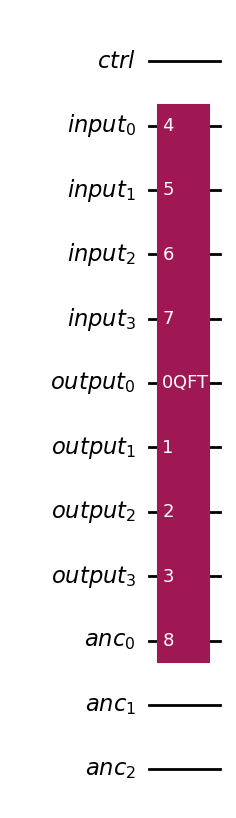

In [107]:
# Create list of qubits representing the full y register:
# Concatenates: output_reg[0 to n-1], input_reg[0 to n-1], ancilla_reg[0]
yreg = list(output_reg) + list(input_reg) + [ancilla_reg[0]]

# Apply QFT to prepare for subtraction
mod_mult_circ.compose(QFT(len(yreg)), qubits=yreg, inplace=True)
mod_mult_circ.draw('mpl')

The section above prepares the quantum register `yreg` — a logical combination of `output`, `input`, and one ancilla qubit — for modular subtraction. The combined register encodes an extended integer value across  $2n + 1$  qubits.

We apply the Quantum Fourier Transform (QFT) to this register to move into the Fourier basis, where arithmetic operations (like subtraction) can be performed efficiently using only phase rotations.

This sets up the circuit to later subtract $N$ by rotating individual qubits, and ultimately detect underflow (i.e., whether $y < N $) in a reversible, measurement-free way.

In [100]:
# Subtract N by applying phase rotations (acts like y - N in Fourier basis)
mod_mult_circ.p(-N * np.pi, ancilla_reg[0])
for k in range(1, n + 1):
    mod_mult_circ.p(-N * np.pi / (1 << k), output_reg[n - k])
    mod_mult_circ.p(-N * np.pi / (1 << (n + k)), input_reg[n - k])

# Inverse QFT to return to computational basis
mod_mult_circ.compose(QFT(len(yreg)).inverse(), qubits=yreg, inplace=True)




# Mark ancilla[2] = 1 iff  y < N)
mod_mult_circ.cx(ancilla_reg[0], ancilla_reg[2])

# Add N back to restore the state (but ancilla[2] remembers y < N)
mod_mult_circ.compose(QFT(len(yreg)), qubits=yreg, inplace=True)
mod_mult_circ.p(N * np.pi, ancilla_reg[0])
for k in range(1, n + 1):
    mod_mult_circ.p(N * np.pi / (1 << k), output_reg[n - k])
    mod_mult_circ.p(N * np.pi / (1 << (n + k)), input_reg[n - k])
mod_mult_circ.compose(QFT(len(yreg)).inverse(), qubits=yreg, inplace=True)

The next 3 steps conclude our construction, first for STEP 1 we set up the modular multiplication circuit by:

- Precomputing rotation angles for the phase rotations required in modular arithmetic with modulus $N$ and multiplier $a$.
- Defining the accumulator register `sum_reg`, which combines the output register with an extra ancilla qubit used to detect arithmetic overflow.
- Applying the Quantum Fourier Transform (QFT) to `sum_reg` so that arithmetic operations can be implemented via phase shifts, enabling efficient modular addition in the Fourier basis.

In [101]:
# Precompute rotation angles for modular arithmetic
a_pow_angles, N_angles, a_inv, a_inv_pow_angles = precompute_modular_angles(N, a)

# The 'sum_reg' register will represent the sum register in the Fourier basis.
# It includes the output register and an extra ancilla qubit to detect overflow
sum_reg = list(output_reg) + [ancilla_reg[0]]

# Step 1: Apply the Quantum Fourier Transform to prepare the breg for arithmetic
mod_mult_circ.compose(QFT(n + 1), qubits=sum_reg, inplace=True)

STEP 2: the circuit performs modular addition of $ 2^i \cdot a \mod N $, controlled on three qubits:

- The underflow flag (`ancilla_reg[2]`),
- The control qubit (activates the multiplication),
- The $ i $-th bit of the input register.

For each bit  in `input_reg`:

- A series of controlled phase rotations are applied to `sum_reg` to simulate the addition of $ 2^i \cdot a \mod N $ in the Fourier basis.
- Then, the circuit subtracts $N $in phase space to detect overflow.
- An inverse QFT brings the register back to the computational basis to allow a classical check of overflow via a CNOT gate.
- The overflow flag is stored in `ancilla_reg[1]`, and the QFT is reapplied.
- If no overflow occurred, the circuit adds $N$ back to correct the result, using the overflow flag as a control.

In [102]:
# For each bit in the input register, apply a controlled addition of 2^i * a mod N
for i in range(n):
    controls = [ancilla_reg[2], control_qubit[0], input_reg[i]]

    # Apply controlled phase rotations to add 2^i * a mod N
    mod_mult_circ.mcp(a_pow_angles[i][0], controls, ancilla_reg[0])
    for k in range(1, n + 1):
        mod_mult_circ.mcp(a_pow_angles[i][k], controls, output_reg[n - k])

    # Subtract N to detect overflow
    mod_mult_circ.cp(-N_angles[0], ancilla_reg[2], ancilla_reg[0])
    for k in range(1, n + 1):
        mod_mult_circ.cp(-N_angles[k], ancilla_reg[2], output_reg[n - k])

    # Inverse QFT to check overflow in computational basis
    mod_mult_circ.compose(QFT(n + 1).inverse(), qubits=sum_reg, inplace=True)
    mod_mult_circ.cx(ancilla_reg[0], ancilla_reg[1])  # Store overflow result
    mod_mult_circ.compose(QFT(n + 1), qubits=sum_reg, inplace=True)

    # Conditionally add N back if no overflow occurred
    mod_mult_circ.mcp(N_angles[0], [ancilla_reg[2], ancilla_reg[1]], ancilla_reg[0])
    for k in range(1, n + 1):
        mod_mult_circ.mcp(N_angles[k], [ancilla_reg[2], ancilla_reg[1]], output_reg[n - k])

STEP 3 (final step) ensures all ancilla qubits are disentangled and restored to their original states.

- First, the previous addition is undone (i.e., uncomputed) to remove any entanglement between the output register and the ancillas.
- Then, a bit-flip trick is applied: a sequence of CNOT gates wrapped around an inverse and forward QFT. This erases residual entanglement between $ \text{ancilla\_reg}[0] $, $[1]$, and $[2]$, commonly referred to as a "Toffoli sandwich".
- After the ancillas are disentangled, the correct modular addition is redone cleanly with the ancillas now reset.
- Finally, an inverse QFT transforms the accumulator register ($\text{sum\_reg}$) back into the computational basis, concluding this part of the modular multiplication circuit.

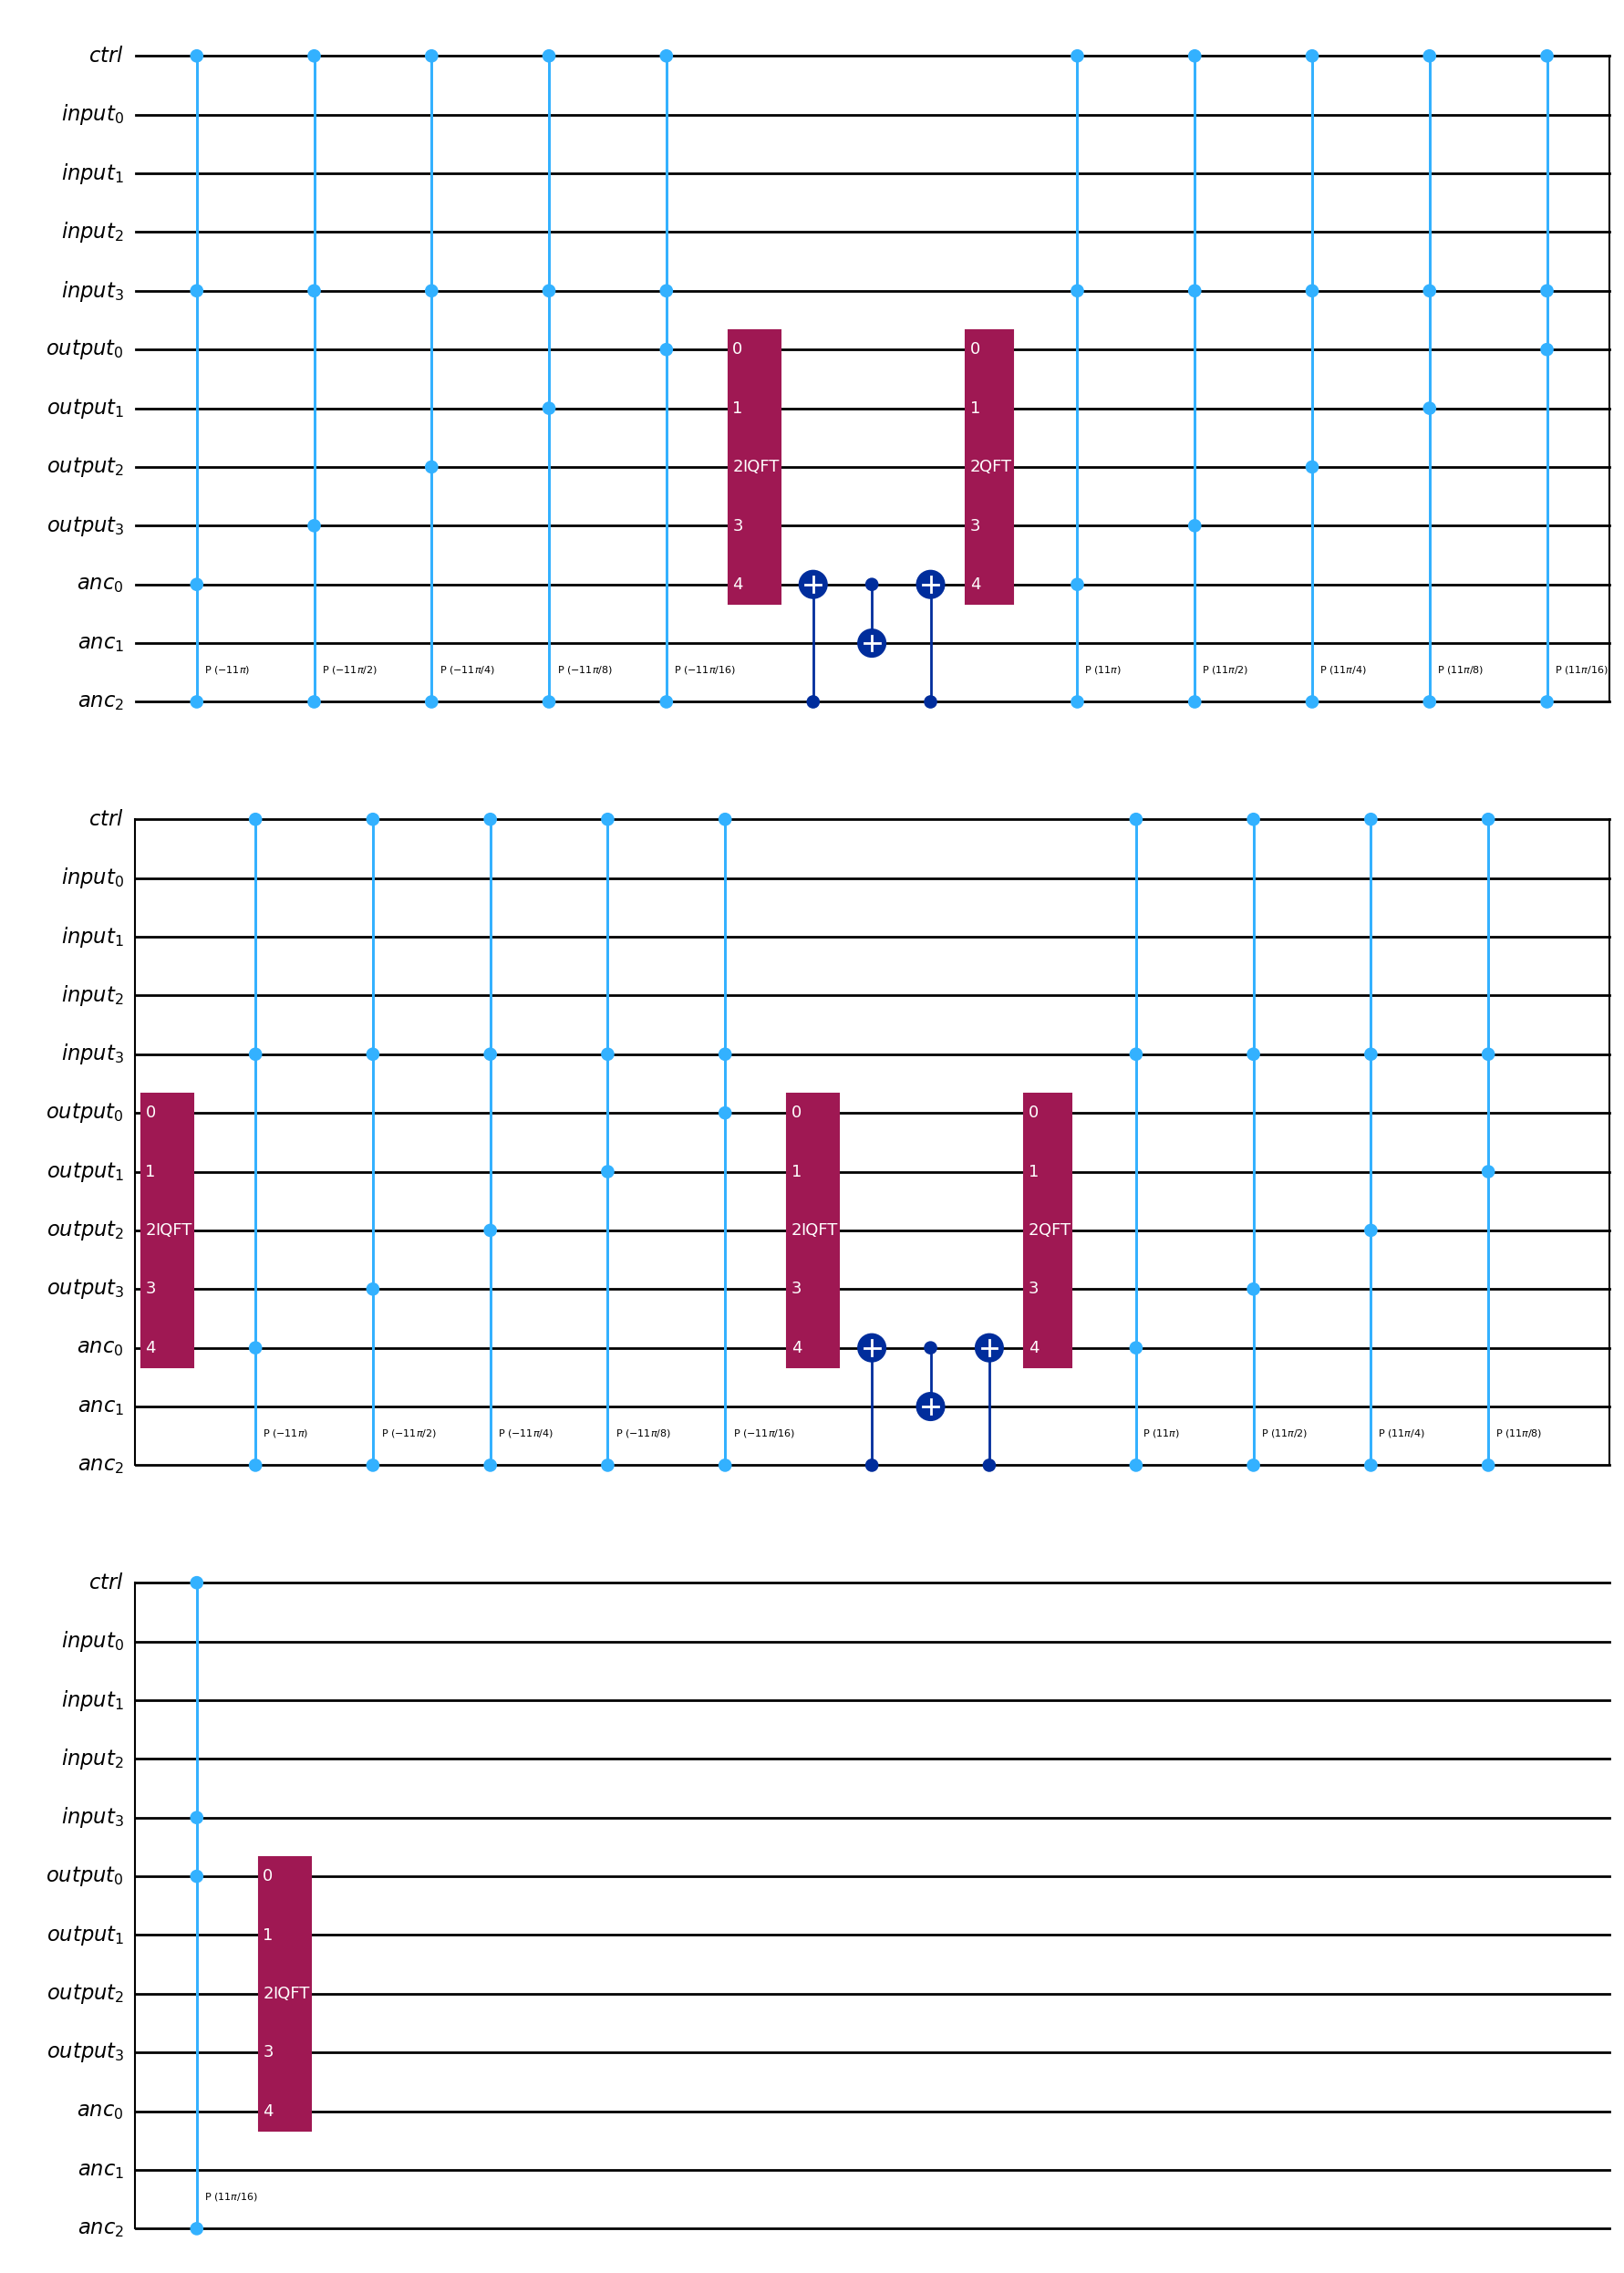

In [151]:
  # Undo previous addition to disentangle ancillas
mod_mult_circ.mcp(-a_pow_angles[i][0], controls, ancilla_reg[0])
for k in range(1, n + 1):
    mod_mult_circ.mcp(-a_pow_angles[i][k], controls, output_reg[n - k])

    # Bit-flip trick to erase entanglement between ancilla[0], [1], [2]
mod_mult_circ.compose(QFT(n + 1).inverse(), qubits=sum_reg, inplace=True)
mod_mult_circ.cx(ancilla_reg[2], ancilla_reg[0])
mod_mult_circ.cx(ancilla_reg[0], ancilla_reg[1])
mod_mult_circ.cx(ancilla_reg[2], ancilla_reg[0])
mod_mult_circ.compose(QFT(n + 1), qubits=sum_reg, inplace=True)

    # Re-apply the correct modular addition cleanly
mod_mult_circ.mcp(a_pow_angles[i][0], controls, ancilla_reg[0])
for k in range(1, n + 1):
    mod_mult_circ.mcp(a_pow_angles[i][k], controls, output_reg[n - k])

# Final inverse QFT to return accumulator to computational basis
mod_mult_circ.compose(QFT(n + 1).inverse(), qubits=sum_reg, inplace=True)

mod_mult_circ.draw('mpl')

Now we put everything together and create the Oracle function

In [131]:
def oracle(a,N):
    """
    Constructs the oracle for modular multiplication by 'a' mod N.
    This oracle applies the controlled modular multiplication operation.
    """
   # We now define our Quantum Register setup 
    n = int(np.ceil(np.log2(N)))
# Control qubit: determines if modular multiplication is applied
    control_qubit = QuantumRegister(1, name="ctrl")

# Input register: holds |y⟩, the value to be multiplied by 'a' mod N
    input_reg = QuantumRegister(n, name="input")

# Output register: holds the result of the desired modular multiplication
    output_reg = QuantumRegister(n, name="output")

# Ancilla qubits: used for temporary computation (we will need 3 ancilla qubits)
    ancilla_reg = QuantumRegister(3, name="anc")

# Construct the circit that combines everything together
    mod_mult_circ = QuantumCircuit(control_qubit, input_reg, output_reg, ancilla_reg, name="mod_mult")
# Create list of qubits representing the full y register:
# Concatenates: output_reg[0 to n-1], input_reg[0 to n-1], ancilla_reg[0]
    yreg = list(output_reg) + list(input_reg) + [ancilla_reg[0]]

# Apply QFT to prepare for subtraction
    mod_mult_circ.compose(QFT(len(yreg)), qubits=yreg, inplace=True)
    
   # Subtract N by applying phase rotations (acts like y - N in Fourier basis)
    mod_mult_circ.p(-N * np.pi, ancilla_reg[0])
    for k in range(1, n + 1):
     mod_mult_circ.p(-N * np.pi / (1 << k), output_reg[n - k])
     mod_mult_circ.p(-N * np.pi / (1 << (n + k)), input_reg[n - k])

# Inverse QFT to return to computational basis
    mod_mult_circ.compose(QFT(len(yreg)).inverse(), qubits=yreg, inplace=True)




# Mark ancilla[2] = 1 iff  y < N)
    mod_mult_circ.cx(ancilla_reg[0], ancilla_reg[2])

# Add N back to restore the state (but ancilla[2] remembers y < N)
    mod_mult_circ.compose(QFT(len(yreg)), qubits=yreg, inplace=True)
    mod_mult_circ.p(N * np.pi, ancilla_reg[0])
    for k in range(1, n + 1):
        mod_mult_circ.p(N * np.pi / (1 << k), output_reg[n - k])
        mod_mult_circ.p(N * np.pi / (1 << (n + k)), input_reg[n - k])
    mod_mult_circ.compose(QFT(len(yreg)).inverse(), qubits=yreg, inplace=True)
# Precompute rotation angles for modular arithmetic
    a_pow_angles, N_angles, a_inv, a_inv_pow_angles = precompute_modular_angles(N, a)

# The 'sum_reg' register will represent the sum register in the Fourier basis.
# It includes the output register and an extra ancilla qubit to detect overflow
    sum_reg = list(output_reg) + [ancilla_reg[0]]

# Step 1: Apply the Quantum Fourier Transform to prepare the breg for arithmetic
    mod_mult_circ.compose(QFT(n + 1), qubits=sum_reg, inplace=True)
    
    # For each bit in the input register, apply a controlled addition of 2^i * a mod N
    for i in range(n):
        controls = [ancilla_reg[2], control_qubit[0], input_reg[i]]


    # Apply controlled phase rotations to add 2^i * a mod N
    mod_mult_circ.mcp(a_pow_angles[i][0], controls, ancilla_reg[0])
    for k in range(1, n + 1):
        if k >= len(a_pow_angles[i]):
            print(f"IndexError about to happen: i={i}, k={k}, len(a_pow_angles[i])={len(a_pow_angles[i])}")
            raise IndexError("a_pow_angles[i] is too short for k")
        mod_mult_circ.mcp(a_pow_angles[i][k], controls, output_reg[n - k])
    # Subtract N to detect overflow
    mod_mult_circ.cp(-N_angles[0], ancilla_reg[2], ancilla_reg[0])
    for k in range(1, n + 1):
        mod_mult_circ.cp(-N_angles[k], ancilla_reg[2], output_reg[n - k])

    # Inverse QFT to check overflow in computational basis
    mod_mult_circ.compose(QFT(n + 1).inverse(), qubits=sum_reg, inplace=True)
    mod_mult_circ.cx(ancilla_reg[0], ancilla_reg[1])  # Store overflow result
    mod_mult_circ.compose(QFT(n + 1), qubits=sum_reg, inplace=True)

    # Conditionally add N back if no overflow occurred
    mod_mult_circ.mcp(N_angles[0], [ancilla_reg[2], ancilla_reg[1]], ancilla_reg[0])
    for k in range(1, n + 1):
        mod_mult_circ.mcp(N_angles[k], [ancilla_reg[2], ancilla_reg[1]], output_reg[n - k])
   
   
        # Undo previous addition to disentangle ancillas
    mod_mult_circ.mcp(-a_pow_angles[i][0], controls, ancilla_reg[0])
    for k in range(1, n + 1):
        mod_mult_circ.mcp(-a_pow_angles[i][k], controls, output_reg[n - k])

    # Bit-flip trick to erase entanglement between ancilla[0], [1], [2]
    mod_mult_circ.compose(QFT(n + 1).inverse(), qubits=sum_reg, inplace=True)
    mod_mult_circ.cx(ancilla_reg[2], ancilla_reg[0])
    mod_mult_circ.cx(ancilla_reg[0], ancilla_reg[1])
    mod_mult_circ.cx(ancilla_reg[2], ancilla_reg[0])
    mod_mult_circ.compose(QFT(n + 1), qubits=sum_reg, inplace=True)

    # Re-apply the correct modular addition cleanly
    mod_mult_circ.mcp(a_pow_angles[i][0], controls, ancilla_reg[0])
    for k in range(1, n + 1):
        mod_mult_circ.mcp(a_pow_angles[i][k], controls, output_reg[n - k])

# Final inverse QFT to return accumulator to computational basis
    mod_mult_circ.compose(QFT(n + 1).inverse(), qubits=sum_reg, inplace=True)
 # Undo previous addition to disentangle ancillas

    return mod_mult_circ

Lets do some testing, recall that we have

In [148]:
def test_oracle(a, N, control_bit, y_value):
    """
    Tests the modular multiplication oracle by preparing an input state,
    applying the oracle, and printing the resulting output.

    Parameters:
    a (int): Multiplier in the modular multiplication.
    N (int): Modulus.
    control_bit (bool): Whether to activate the control qubit.
    y_value (int): Initial value in |y⟩ input register.
    """

    n = int(np.ceil(np.log2(N)))  # Number of bits to represent N

    # Define quantum registers
    ctrl_qubit = QuantumRegister(1, name="ctrl")
    data_register = QuantumRegister(2 * n, name="data")  # Combines input and output registers if needed
    ancilla_register = AncillaRegister(3, name="anc")

    # Initialize quantum circuit
    circuit = QuantumCircuit(ctrl_qubit, data_register, ancilla_register)

    # Prepare control qubit if specified
    if control_bit:
        circuit.x(ctrl_qubit)

    # Prepare input data register to represent y_value
    y_bits = [(y_value >> k) & 1 for k in range(2 * n)]
    for i in range(2 * n):
        if y_bits[i]:
            circuit.x(data_register[i])

    # Apply the modular multiplication oracle
    circuit.compose(oracle(a, N), inplace=True)

    # Simulate the circuit to obtain the output statevector
    state = Statevector(circuit)
    probabilities = np.array(state.probabilities())
    max_state_index = np.argmax(probabilities)

    # Decode the measured bits from max probability state
    total_qubits = 2 * n + 4
    measured_bits = [(max_state_index >> k) & 1 for k in range(total_qubits)]

    # Compute the decoded |y> output value for display
    output_value = (max_state_index >> 1) % (1 << (2 * n))

    # Print results
    print("Max probability at state index:", max_state_index)
    #print("Measured bits:", measured_bits)
    #print("Max probability value:", np.max(probabilities))
    #print(f"Decoded |y> output value: {output_value}")

In [149]:
test_oracle(4,15,True,3)

Max probability at state index: 2055


In [150]:
test_oracle(8,15,True,11)

Max probability at state index: 2199
